# [COMP3610 Big Data Analytics - Project](https://github.com/3-And-1-2-Men/COMP3610-Project)

Project Title: **Spotify Mood Playlist Generator**<br>
Group Name: [Team 3 & A 1/2 Men](https://github.com/3-And-1-2-Men) (Group A)<br>
Group Members:
- [Shaniah Baldeo](https://github.com/officialshayb)
- [Vinaayaka Seelal](https://github.com/Vseelal)
- [Virendra Narine](https://github.com/Vir21)
- [Keshan Moosai](https://github.com/madmoose02)
<br>

Click [here](https://github.com/3-And-1-2-Men/COMP3610-Project) to explore this project's github repository.

<br> **Table of contents**<a id='toc0_'></a>    
- [**Dependencies and Imports**](#toc1_1_)    
- [**Data Routes**](#toc1_2_)    
- [**Spotify Data Pre-processing**](#toc2_)    
  - [Merge Timbre values scraped from the Spotify Web API ](#toc2_1_)    
  - [Normalise Song Features](#toc2_2_)    
  - [Initial Visualisations of Various Features vs. Tempo](#toc2_3_)    
  - [Justifying Outlier Removal in Tempo Column](#toc2_4_)    
  - [Justifying Outlier Removal in Timbre Column](#toc2_5_)    
  - [Visualising Tempo vs Key](#toc2_6_)    
- [**Music Mood Classification**](#toc3_)    
  - [Extracting Ideal Cases in Spotify Dataset](#toc3_1_)    
  - [Visualisation of Clustering Behaviour of Ideal Cases](#toc3_2_)    
  - [Support Vector Machine (SVM) for Music Mood Classification](#toc3_3_)    
  - [Use SVM to Classify Spotify Data](#toc3_4_)    
  - [Visualise Distribution of Music Categorisation](#toc3_5_)    
  - [Visualise SVM Boundary Surface Conditions](#toc3_6_)    
- [**Google Emotions Data Pre-processing**](#toc4_)    
  - [Initial Trimming of Useless Columns](#toc4_1_)    
  - [Rationale for dropping rest of columns](#toc4_2_)    
  - [Google Emotions Dataset Text Cleaning](#toc4_3_)    
  - [Reverse One-Hot on Google Emotions Dataset](#toc4_4_)    
  - [Emotions Data Train/Test Split](#toc4_5_)    
- [**Emotion Detection**](#toc5_)    
  - [Logit Model + TFIDF](#toc5_1_)    
  - [Logit Model + TFIDF + Ngram](#toc5_2_)    
  - [Recurrent Neural Network using Long-Short Term Memory (LSTM)](#toc5_3_)    
- [**Playlist Generation**](#toc6_)    
  - [Model Loading](#toc6_1_)    
  - [Data Capturing](#toc6_2_)    
  - [Randomly Select 100 Songs of Predicted Mood](#toc6_3_)    
  - [Generate Playlist for User](#toc6_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_'></a>[**Dependencies and Imports**](#toc0_)

In [2]:
import re
import random
import spotipy
import numpy as np
import pandas as pd
import seaborn as sns

from os import path

from matplotlib import pyplot as plt
from spotipy.oauth2 import SpotifyOAuth

from nltk import download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.metrics import Accuracy, Precision
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kesha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kesha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kesha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### <a id='toc1_2_'></a>[**Data Routes** (DO NOT MODIFY)](#toc0_)

In [3]:
spotify_master_url   = 'data/spotify_master.csv'
timbre_data_url      = 'data/spotify_tracks_timbre.csv'
emotions_data_url    = 'data/go_emotions_dataset.csv'
classified_songs_url = 'data/classified_spotify_data.csv'
# spotify_master_url   = 'https://media.githubusercontent.com/media/3-And-1-2-Men/COMP3610-Project/main/data/spotify_master.csv'
# timbre_data_url      = 'https://media.githubusercontent.com/media/3-And-1-2-Men/COMP3610-Project/main/data/spotify_tracks_timbre.csv'
# emotions_data_url    = 'https://media.githubusercontent.com/media/3-And-1-2-Men/COMP3610-Project/main/data/go_emotions_dataset.csv'
# classified_songs_url = 'https://media.githubusercontent.com/media/3-And-1-2-Men/COMP3610-Project/main/data/classified_spotify_data.csv'

## <a id='toc2_'></a>[**Spotify Data Pre-processing**](#spotify-data-pre-processing) [&#8593;](#toc0_)

In [64]:
spotify_data = pd.read_csv(spotify_master_url)

In [65]:
spotify_data.describe()

,energy,key,tempo
count,1.204025e+06,1.204025e+06,1.204025e+06
mean,5.095363e-01,5.194151e+00,1.176344e+02
std,2.946839e-01,3.536731e+00,3.093705e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.520000e-01,2.000000e+00,9.405400e+01
50%,5.240000e-01,5.000000e+00,1.167260e+02
75%,7.660000e-01,8.000000e+00,1.370460e+02
max,1.000000e+00,1.100000e+01,2.489340e+02


In [66]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1204025 non-null  object 
 1   energy  1204025 non-null  float64
 2   key     1204025 non-null  int64  
 3   tempo   1204025 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 36.7+ MB


Dropping features from the data `instrumentalness`, `liveness`, `time_signature`, `year`, `release_date`, `album_id`, `album`, `artist_ids`, `track_number`, `disc_number`, `explicit`, `danceability`, `acousticness`, `duration_ms`, `artists`, `mode`, `loudness`, `speechiness` and `valence`.

In summary, the most helpful features kept are: `id`, `energy` `key` and `tempo`

### <a id='toc2_1_'></a>Merge Timbre values scraped from the [Spotify Web API](https://developer.spotify.com/documentation/web-api)  [&#8593;](#toc0_)

In [67]:
timbre_data = pd.read_csv(timbre_data_url)

In [68]:
# Drop all the HTTP status values
timbre_data = timbre_data.drop(['status'], axis=1)

In [69]:
# Sum the timbre vector
def sum_timbre_vector(timbre):
    timbre = re.findall(r"[-+]?\d*\.\d+|\d+", timbre)
    timbre = [float(i) for i in timbre]
    return sum(timbre)

# Apply function on timbre column in df2
timbre_data['timbre'] = timbre_data['timbre'].apply(sum_timbre_vector)

In [70]:
# Merge the two dataframes
spotify_data = pd.merge(spotify_data, timbre_data, on="id")
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44166 entries, 0 to 44165
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      44166 non-null  object 
 1   energy  44166 non-null  float64
 2   key     44166 non-null  int64  
 3   tempo   44166 non-null  float64
 4   timbre  44166 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.7+ MB


### <a id='toc2_2_'></a>[Normalise Song Features](#toc0_)
Note the following:
- The maximum possible key value is $11$ according to the [Spotify Web API Track Audio Features Documentation](https://developer.spotify.com/documentation/web-api/reference/get-audio-features)
- The maximum possible timbre is $12$ (summation of values in 12-vector that range from $0 - 1$) according to the [Spotify Web API Track Audio Analysis Documentation](https://developer.spotify.com/documentation/web-api/reference/get-audio-analysis)
- The energy values are already in a normalised range of $0 - 1$
- The tempo column was chosen not to be normalised since we have no official documentation nor research that can provided a maximum tempo value. In fact, multiple sources indicate that the tempo of music is _indeed_ unbounded

In [71]:
def normalise_timbre(timbre): return round((timbre / 12), 3)
def normalise_energy(energy): return round(energy, 3)
def normalise_key(key): return 0 if key <= 0 else round((key / 11), 3)

spotify_data['timbre'] = spotify_data['timbre'].apply(normalise_timbre)
spotify_data['energy'] = spotify_data['energy'].apply(normalise_energy)
spotify_data['key']    = spotify_data['key'].apply(normalise_key)
MAX_TEMPO = spotify_data['tempo'].max()

In [72]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44166 entries, 0 to 44165
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      44166 non-null  object 
 1   energy  44166 non-null  float64
 2   key     44166 non-null  float64
 3   tempo   44166 non-null  float64
 4   timbre  44166 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.7+ MB


In [73]:
spotify_data.describe()

,energy,key,tempo,timbre
count,44166.000000,44166.000000,44166.000000,44166.000000
mean,0.509602,0.496858,117.648994,0.499321
std,0.295254,0.310074,30.882844,0.230685
min,0.000000,0.000000,0.000000,0.085000
25%,0.253000,0.182000,94.183750,0.313000
50%,0.524000,0.545000,116.523500,0.480000
75%,0.767000,0.818000,137.016000,0.659000
max,1.000000,1.000000,222.859000,1.000000


### <a id='toc2_3_'></a>[Initial Visualisations of Various Features vs. Tempo](#toc0_)

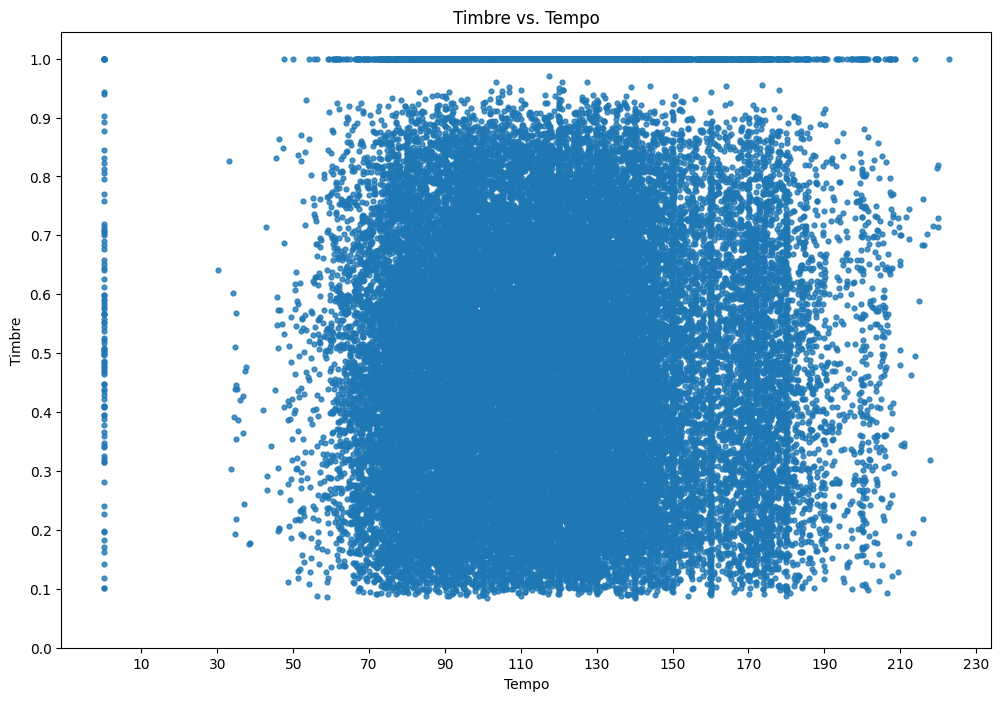

In [74]:
plt.figure(figsize=(12, 8))
plt.title('Timbre vs. Tempo')
plt.scatter(spotify_data['tempo'], spotify_data['timbre'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(10, 240, 20))
plt.ylabel('Timbre')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

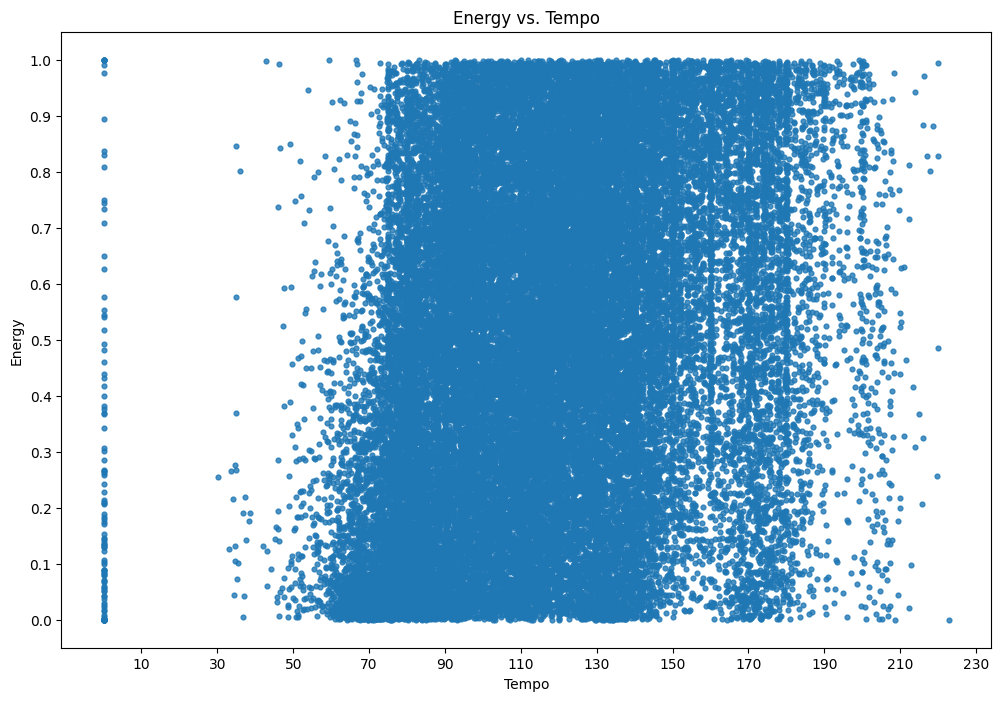

In [75]:
plt.figure(figsize=(12, 8))
plt.title('Energy vs. Tempo')
plt.scatter(spotify_data['tempo'], spotify_data['energy'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(10, 240, 20))
plt.ylabel('Energy')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

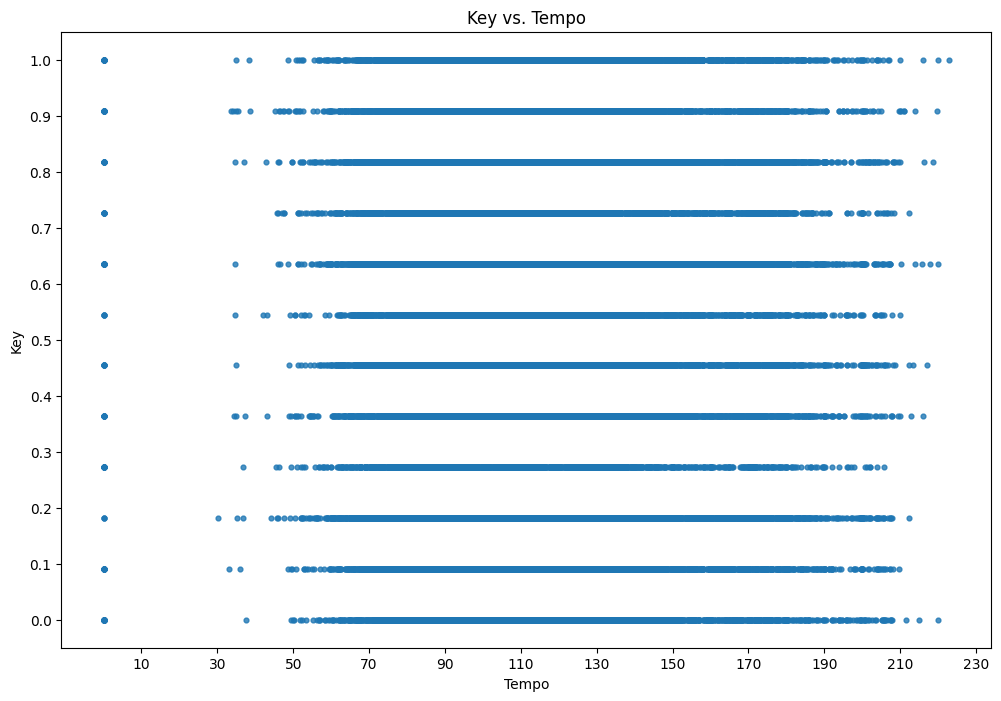

In [76]:
plt.figure(figsize=(12, 8))
plt.title('Key vs. Tempo')
plt.scatter(spotify_data['tempo'], spotify_data['key'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(10, 240, 20))
plt.ylabel('Key')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

### <a id='toc2_4_'></a>[Justifying Outlier Removal in Tempo Column](#toc0_)
We can see that there are consistent outliers in the dataset's tempo values: values less than 10 can be safely eradicated since there exists a clear disparity between tempo values less than 10 and those greater than 10

In [77]:
tempo_outliers = np.where(spotify_data['tempo'] <= 10)
spotify_data = spotify_data.drop(tempo_outliers[0])
spotify_data = spotify_data.reset_index(drop=True)

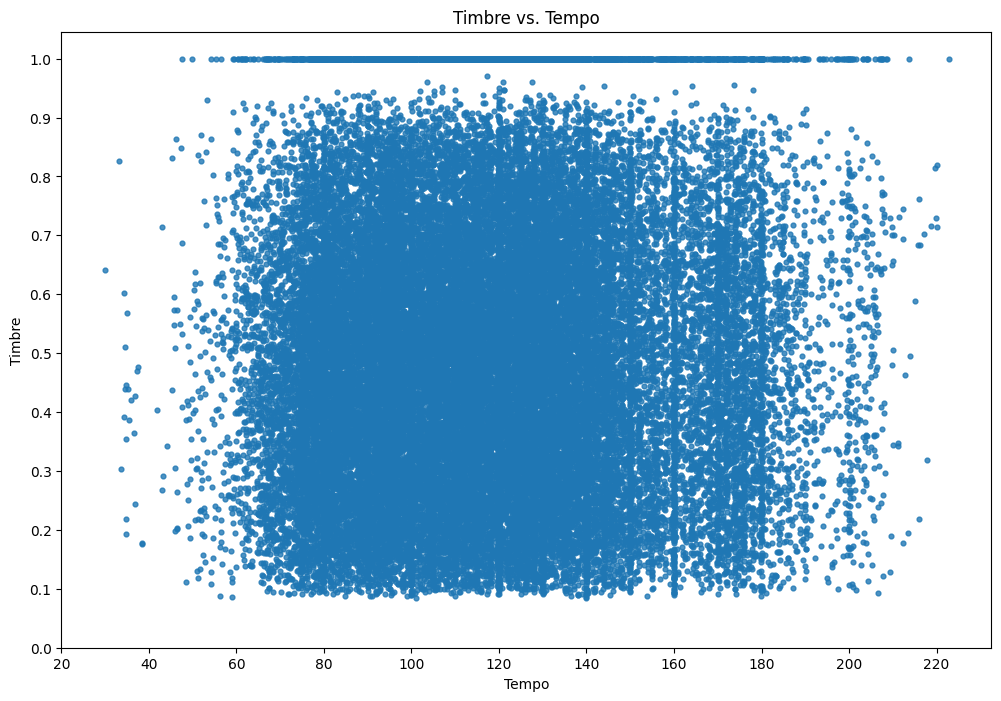

In [78]:
plt.figure(figsize=(12, 8))
plt.title('Timbre vs. Tempo')
plt.scatter(spotify_data['tempo'], spotify_data['timbre'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(20, 240, 20))
plt.ylabel('Timbre')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

### <a id='toc2_5_'></a>[Justifying Outlier Removal in Timbre Column](#toc0_)
We can observe that there seem to be a value of 1 for timbre vectors that are set to the default state (no data available). As such, these datapoints will be dropped.

In addition, the timbre values that are less than 0.05 seem to add no relative value to the main data cluster. Resultantly, they will also be removed

In [79]:
timbre_outliers = np.where((spotify_data['timbre'] <= 0.05) | (spotify_data['timbre'] == 1.0))
spotify_data = spotify_data.drop(timbre_outliers[0])
spotify_data = spotify_data.reset_index(drop=True)

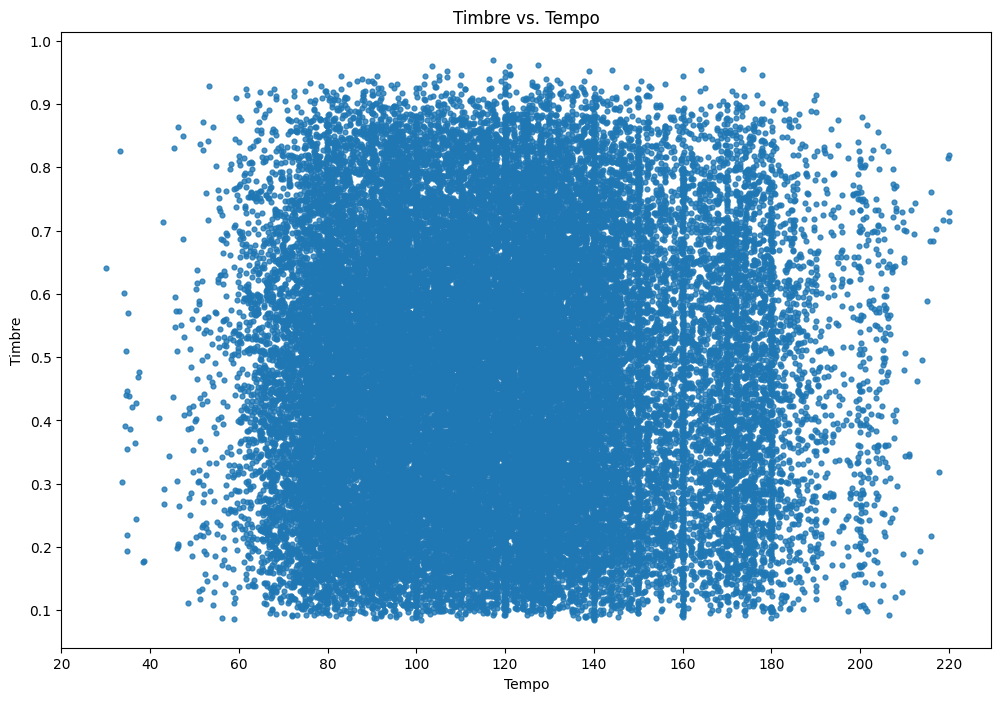

In [80]:
plt.figure(figsize=(12, 8))
plt.title('Timbre vs. Tempo')
plt.scatter(spotify_data['tempo'], spotify_data['timbre'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(20, 240, 20))
plt.ylabel('Timbre')
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.show()

### <a id='toc2_6_'></a>[Visualising Tempo vs Key](#toc0_)

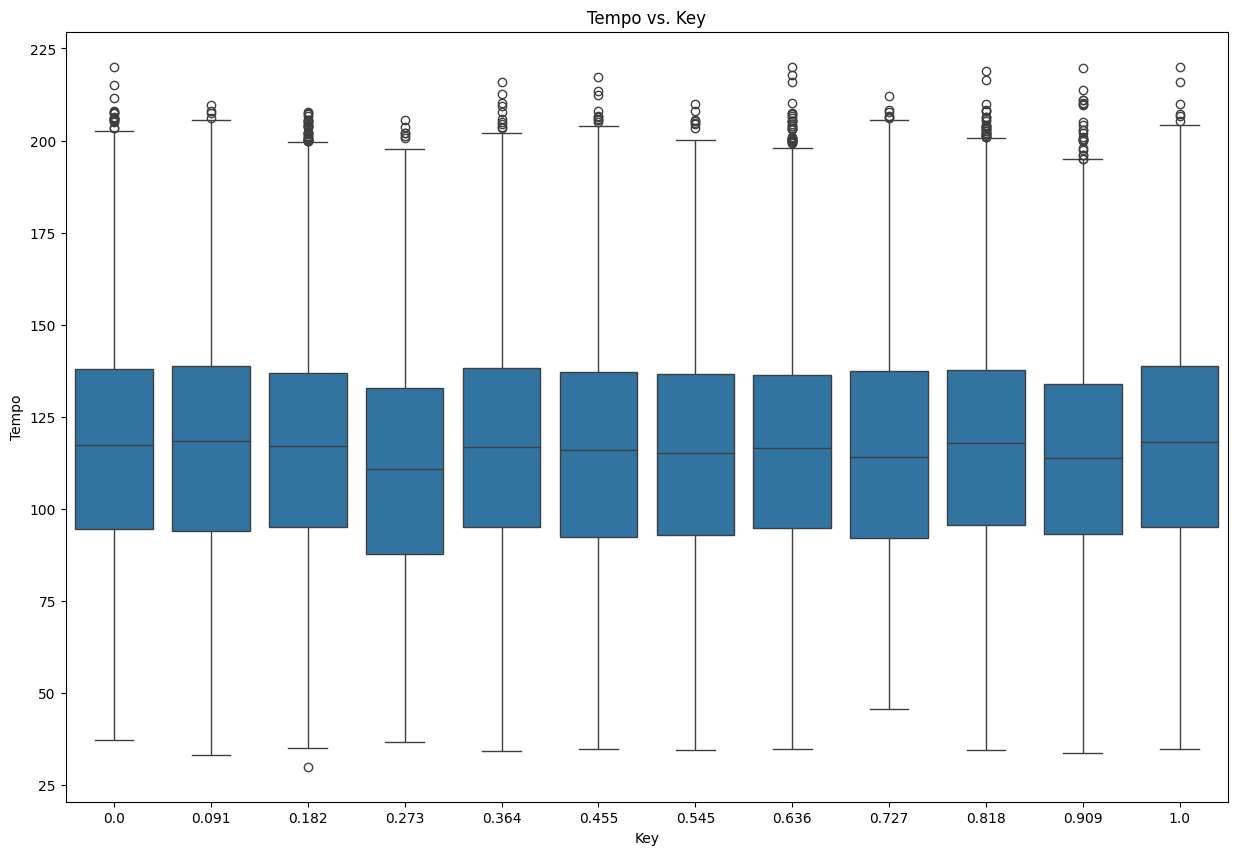

In [22]:
plt.figure(figsize=(15, 10))
plt.title('Tempo vs. Key')
sns.boxplot(x=spotify_data['key'], y=spotify_data['tempo'])
plt.xlabel('Key')
plt.ylabel('Tempo')
plt.xticks(np.arange(0, 12, 1))
plt.show()

## <a id='toc3_'></a>[**Music Mood Classification Model**](#music-mood-classification) [&#8593;](#toc0_)

### <a id='toc3_1_'></a>[Extracting Ideal Cases in Spotify Dataset](#toc0_)
According to [research](https://sites.tufts.edu/eeseniordesignhandbook/2015/music-mood-classification/), the following ranges were extrapolated from mean values of the features that indicate a particular mood. We have decided to fine tune these ranges such that they are able to detect and classify a substantial number of songs per mood.

In [81]:
features = {
    "energy" : 0,
    "timbre" : 1,
    "key"    : 2,
    "tempo"  : 3
}

moods = {
  "Happy":       [(0.4, 0.6), (0.3, 0.5), (0.7, 1.0), (175, MAX_TEMPO)],
  "Exuberant":   [(0.6, 0.8), (0.3, 0.5), (0.6, 0.7), (160, 175)],
  "Energetic":   [(0.8, 1.0), (0.3, 0.5), (0.4, 0.6), (160, 175)],
  "Frantic":     [(0.6, 0.8), (0.6, 1.0), (0.2, 0.4), (175, MAX_TEMPO)],
  "Sad":         [(0.4, 0.6), (0.0, 0.2), (0.0, 0.2), (75,  100)],
  "Depression":  [(0.2, 0.4), (0.2, 0.3), (0.2, 0.4), (75,  100)],
  "Calm":        [(0.0, 0.2), (0.0, 0.2), (0.4, 0.6), (0,    75)],
  "Contentment": [(0.2, 0.4), (0.2, 0.3), (0.6, 0.7), (75,  100)]
}

Using the above ranges to pull out 'ideal' cases

In [82]:
ideal_cases = {
  "Happy" : [],
  "Exuberant" : [],
  "Energetic" : [],
  "Frantic" : [],
  "Sad" : [],
  "Depression" : [],
  "Calm" : [],
  "Contentment" : []
}

def check_range(value: float, range): return range[0] <= value < range[1]

# Pull ideal cases from data file
for idx, row in enumerate(spotify_data.index):
    for mood in ideal_cases.keys():
        if check_range(spotify_data['energy'][idx], moods[mood][features['energy']]) and \
           check_range(spotify_data['timbre'][idx], moods[mood][features['timbre']]) and \
           check_range(spotify_data['key'][idx],    moods[mood][features['key']])    and \
           check_range(spotify_data['tempo'][idx],  moods[mood][features['tempo']]):
            ideal_cases[mood].append(spotify_data.iloc[idx])

# Generate new sample points
max_points = 70
test_data  = spotify_data.drop(columns=["id"])
for mood in ideal_cases.keys():
    print(f"Added {max_points - len(ideal_cases[mood])} to {mood} category")
    for x in range(0, max_points - len(ideal_cases[mood])):
        rand_energy = round(random.uniform(moods[mood][features['energy']][0], moods[mood][features['energy']][1]), 3)
        rand_timbre = round(random.uniform(moods[mood][features['timbre']][0], moods[mood][features['timbre']][1]), 3)
        rand_key    = round(random.uniform(moods[mood][features['key']][0],    moods[mood][features['key']][1]), 3)
        rand_tempo  = np.random.randint(moods[mood][features['tempo']][0],  moods[mood][features['tempo']][1])
        df = pd.DataFrame(columns=test_data.columns, data=[[rand_energy, rand_key, rand_tempo, rand_timbre]])
        ideal_cases[mood].append(df.iloc[0])

print("Total number of samples per mood:", len(ideal_cases['Happy']))

Added 45 to Happy category
Added 54 to Exuberant category
Added 30 to Energetic category
Added 60 to Frantic category
Added -1 to Sad category
Added 28 to Depression category
Added 48 to Calm category
Added 15 to Contentment category
Total number of samples per mood: 70


In [83]:
ideal_cases_df = pd.concat([pd.DataFrame(ideal_cases[mood], columns=spotify_data.columns) for mood in ideal_cases.keys()])
ideal_cases_df['mood'] = [mood for mood in ideal_cases.keys() for _ in range(len(ideal_cases[mood]))]
ideal_cases_df = ideal_cases_df.reset_index(drop=True)
ideal_cases_df = ideal_cases_df.drop(columns=['id'])

### <a id='toc3_2_'></a>[Visualisation of Clustering Behaviour of Ideal Cases](#toc0_)

The music is organised into 8 categories: `Happy`, `Exuberant`, `Energetic`, `Frantic`, `Sad`, `Depression`, `Calm`, `Contentment`

We will now extract data points that match the exact ranges that define each of these categories

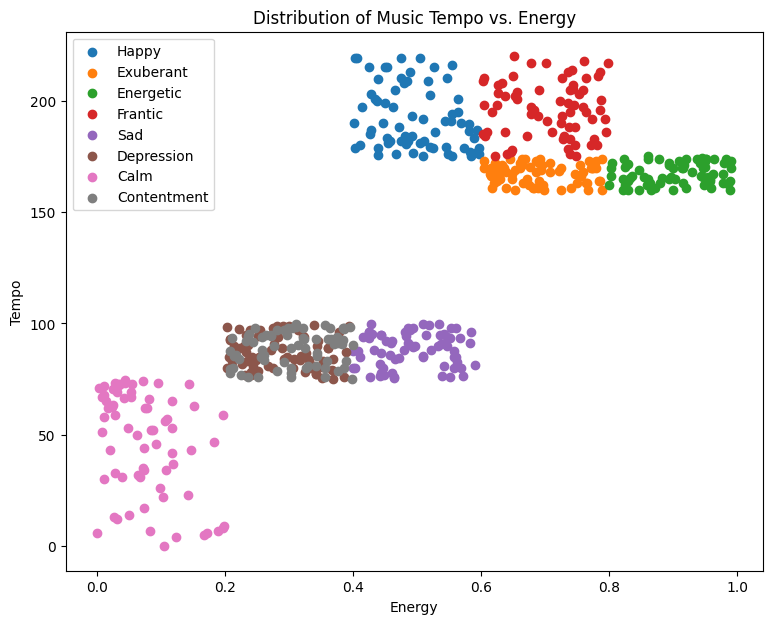

In [84]:
plt.figure(figsize=(9,7))
for mood in ideal_cases.keys():
    X = [x['energy'] for x in ideal_cases[mood]]
    Y = [x['tempo'] for x in ideal_cases[mood]]
    plt.scatter(X, Y, label=mood)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Tempo')
plt.title('Distribution of Music Tempo vs. Energy')
plt.show()

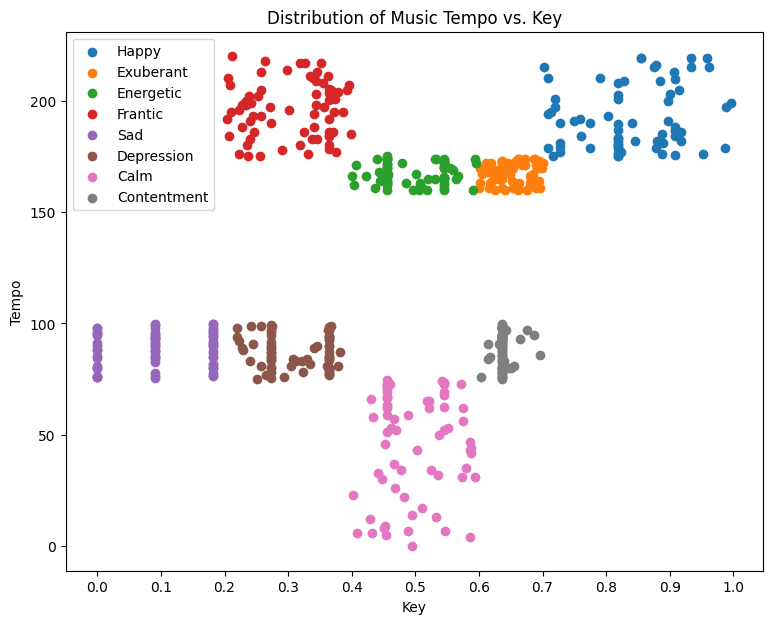

In [85]:
plt.figure(figsize=(9,7))
for mood in ideal_cases.keys():
    X = [x['key'] for x in ideal_cases[mood]]
    Y = [x['tempo'] for x in ideal_cases[mood]]
    plt.scatter(X, Y, label=mood)
plt.legend()
plt.xlabel('Key')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Tempo')
plt.title('Distribution of Music Tempo vs. Key')
plt.show()


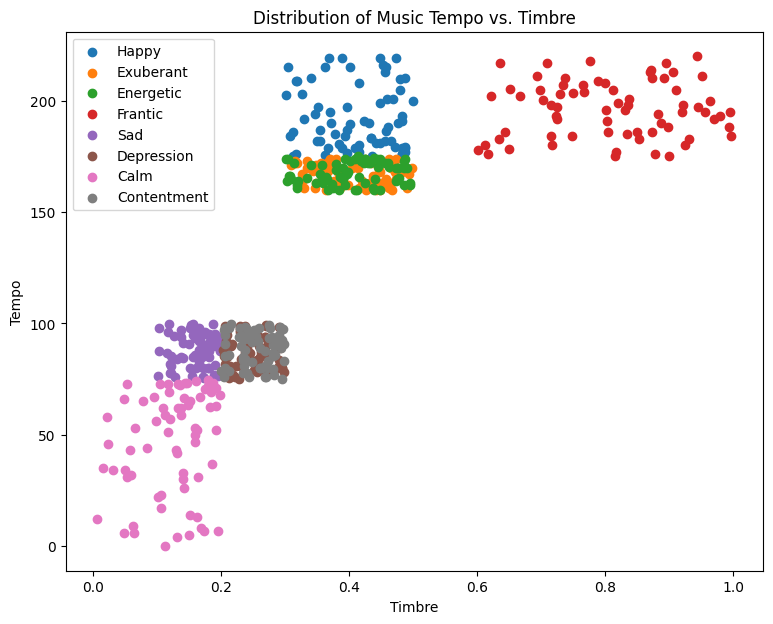

In [86]:
plt.figure(figsize=(9,7))
for mood in ideal_cases.keys():
    X = [x['timbre'] for x in ideal_cases[mood]]
    Y = [x['tempo'] for x in ideal_cases[mood]]
    plt.scatter(X, Y, label=mood)
plt.legend()
plt.xlabel('Timbre')
plt.ylabel('Tempo')
plt.title('Distribution of Music Tempo vs. Timbre')
plt.show()

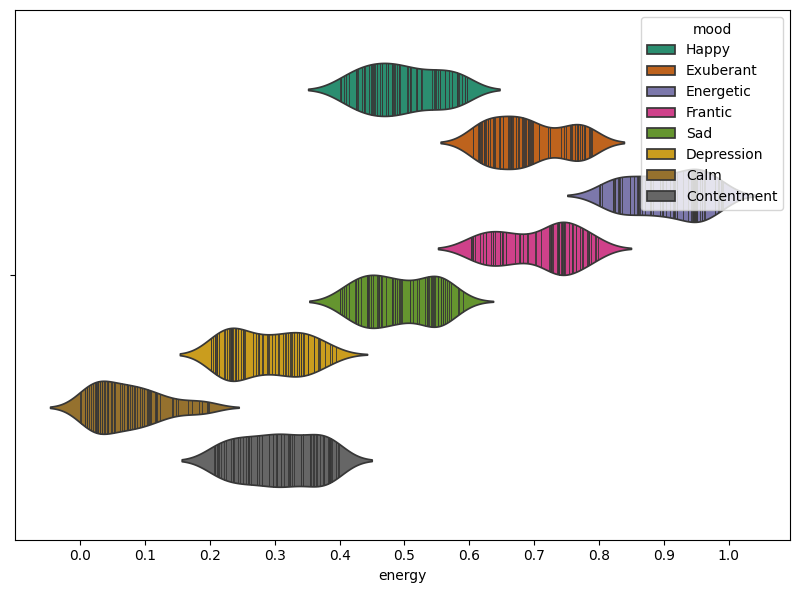

In [87]:
figsize = (10, 0.86 * len(ideal_cases_df['mood'].unique()))
plt.figure(figsize=figsize)
plt.xticks(np.arange(0, 1.1, 0.1))
sns.violinplot(ideal_cases_df, x='energy', hue='mood', inner='stick', palette='Dark2')
plt.show()

### <a id='toc3_3_'></a>[Support Vector Machine (SVM) for Music Mood Classification](#toc0_)

In [88]:
# import warnings
# warnings.filterwarnings('ignore')
svm_clf = LinearSVC(dual='auto', max_iter=180000, random_state=32)

# Separate features and target
X = ideal_cases_df.drop('mood', axis=1)
y = ideal_cases_df['mood']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [89]:
# Train the model
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8849557522123894


In [90]:
tests = {
  'Happy 1'       : {'energy':0.79, 'key':0.45, 'tempo':100, 'timbre':0.30},    # Bastille - happier
  'Happy 2'       : {'energy':0.76, 'key':0.45, 'tempo':160, 'timbre':0.52},    # pharrell williams - happy
  'Sad 1'         : {'energy':0.39, 'key':0.00, 'tempo':134, 'timbre':0.24},    # xxxtentacion - jocelyn flores
  'Sad 2'         : {'energy':0.81, 'key':0.64, 'tempo':104, 'timbre':0.14},    # green day - when sept ends
  'Energetic 1'   : {'energy':0.97, 'key':0.70, 'tempo':142, 'timbre':0.33},    # marshmello - check this out
  'Energetic 2'   : {'energy':0.67, 'key':0.64, 'tempo':159, 'timbre':0.23},    # Marimba - Gangnam Style
  'Energetic 3'   : {'energy':0.87, 'key':0.73, 'tempo':130, 'timbre':0.79},    # YOASOBI - racing into the night
  'Exuberant'     : {'energy':0.96, 'key':0.50, 'tempo':160, 'timbre':0.84},    # ke$ha, pitbull - timbre
  'Contentment 1' : {'energy':0.45, 'key':0.75, 'tempo':89,  'timbre':0.81},    # UB40 - red red wine
  'Contentment 2' : {'energy':0.35, 'key':0.27, 'tempo':144, 'timbre':0.38},    # Vancouver Sleep Clinic - 405
  'Depression'    : {'energy':0.32, 'key':0.64, 'tempo':148, 'timbre':0.26}     # skylar grey - words
}

# Predict examples
for key, value in tests.items():
    predicted_mood = svm_clf.predict(pd.DataFrame([value]))
    print("Acutal Song Mood:",key,f"{(14 - len(key)) * ' '}","Predicted Mood:",predicted_mood[0])

Acutal Song Mood: Happy 1         Predicted Mood: Energetic
Acutal Song Mood: Happy 2         Predicted Mood: Energetic
Acutal Song Mood: Sad 1           Predicted Mood: Sad
Acutal Song Mood: Sad 2           Predicted Mood: Energetic
Acutal Song Mood: Energetic 1     Predicted Mood: Energetic
Acutal Song Mood: Energetic 2     Predicted Mood: Exuberant
Acutal Song Mood: Energetic 3     Predicted Mood: Contentment
Acutal Song Mood: Exuberant       Predicted Mood: Energetic
Acutal Song Mood: Contentment 1   Predicted Mood: Contentment
Acutal Song Mood: Contentment 2   Predicted Mood: Depression
Acutal Song Mood: Depression      Predicted Mood: Happy


### <a id='toc3_4_'></a>[Use SVM to Classify Spotify Data](#toc0_)

In [91]:
y_pred_all = svm_clf.predict(spotify_data.drop(columns=['id']))
spotify_data['mood'] = y_pred_all
spotify_data.to_csv("data/classified_spotify_data.csv", index=False)

### <a id='toc3_5_'></a>[Visualise Distribution of Music Categorisation](#toc0_)

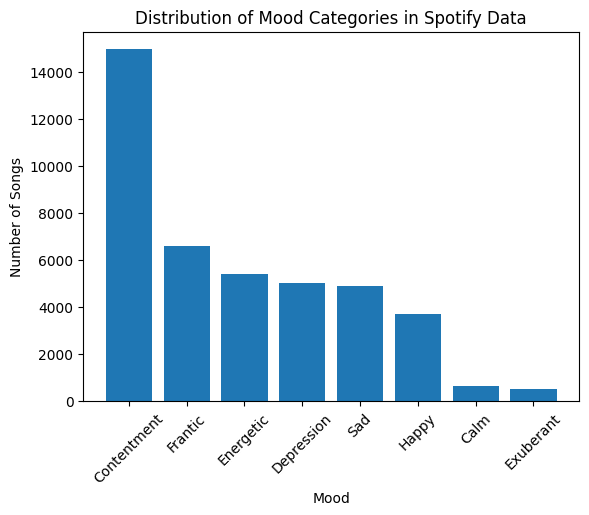

In [92]:
# Count the number of songs in each mood category
mood_counts = spotify_data['mood'].value_counts()

# Create a bar chart of the mood counts
plt.bar(mood_counts.index, mood_counts.values)
plt.xlabel('Mood')
plt.ylabel('Number of Songs')
plt.title('Distribution of Mood Categories in Spotify Data')
plt.xticks(rotation=45)
plt.show()


### <a id='toc3_6_'></a>[Visualise SVM Boundary Surface Conditions](#toc0_)

In [93]:
label_map = {
  'Happy': 0,
  'Exuberant': 1,
  'Energetic': 2,
  'Frantic': 3,
  'Sad': 4,
  'Depression': 5,
  'Calm': 6,
  'Contentment': 7
}
y = [label_map[x] for x in y]

In [94]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = Z.astype(np.float64)
    out = ax.contourf(xx, yy, Z, **params)
    return out

pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X)
Xreduced = Xreduced.astype(np.float64)

In [95]:
# Fit SVM to PCA reduced data
svm_clf.fit(Xreduced, y)

LinearSVC(dual='auto', max_iter=180000, random_state=32)

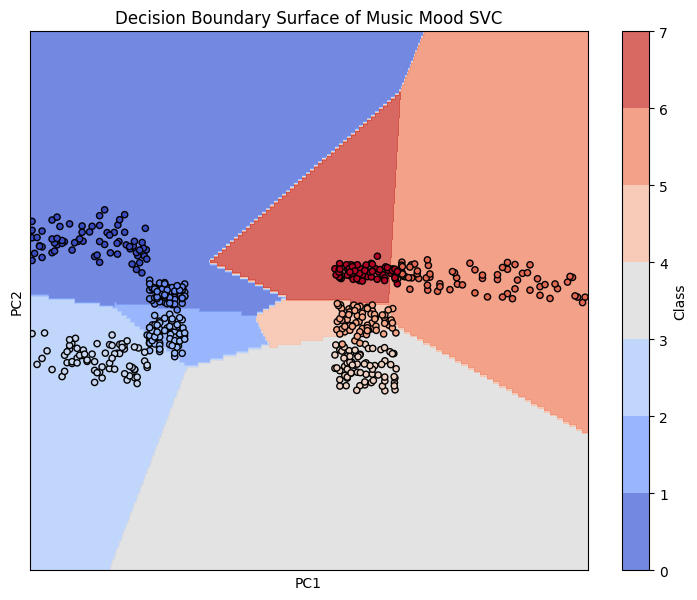

In [177]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(9)
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
out = plot_contours(ax, svm_clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

# Add a colorbar
plt.colorbar(out, label='Class')

ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decision Boundary Surface of Music Mood SVC')
plt.show()

## <a id='toc4_'></a>[**Google Emotions Data Pre-processing**](#emotions-data-pre-processing) [&#8593;](#toc0_)

In [7]:
df = pd.read_csv(emotions_data_url)

### <a id='toc4_1_'></a>[Initial Trimming of Useless Columns](#toc0_)

In [8]:
df = df.drop(columns=['id'])

cols_to_drop = ['example_very_unclear', 'neutral', 'disgust', 'desire', 'anger', 'annoyance', 'confusion', 'embarrassment', 'approval', 'disapproval', 'surprise']

# Remove rows with any of the above class labels
df = df.drop(df[(df[cols_to_drop] == 1).any(axis=1)].index)

# Drop the columns and reset the index
df = df.drop(columns=cols_to_drop)
df = df.reset_index(drop=True)
df

,text,admiration,amusement,caring,curiosity,disappointment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness
0,That game hurt.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Man I love reddit.,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Right? Considering it’s such an important docu...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,That's crazy; I went to a super [RELIGION] hig...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,that's adorable asf,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83903,"Thanks, [NAME]",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
83904,"Well, I'm glad you're out of all that now. How...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
83905,Everyone likes [NAME].,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
83906,Well when you’ve imported about a gazillion of...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
emotions_map = {
    "calm":        ["relief"],
    "energetic":   ["excitement"],
    "frantic":     ["fear"],
    "exuberant":   ["amusement"],
    "happy":       ["joy"],
    "sad":         ["sadness"],
    "depression":  ["grief", "remorse"],
    "contentment": ["gratitude"]
}

for emotion in emotions_map.keys(): df[emotion] = None

In [10]:
for index, row in df.iterrows():
    for emotion in emotions_map:
        x = emotions_map[emotion]
        df.at[index, emotion] = 1 if sum((df.at[index, x[i]]) for i in range(0, len(x))) >= 1 else 0

In [11]:
calm_count        = df[df['calm']        == 1]['calm'].sum()
energetic_count   = df[df['energetic']   == 1]['energetic'].sum()
frantic_count     = df[df['frantic']     == 1]['frantic'].sum()
exuberant_count   = df[df['exuberant']   == 1]['exuberant'].sum()
happy_count       = df[df['happy']       == 1]['happy'].sum()
sad_count         = df[df['sad']         == 1]['sad'].sum()
depression_count  = df[df['depression']  == 1]['depression'].sum()
contentment_count = df[df['contentment'] == 1]['contentment'].sum()
print('Calm:', calm_count)
print('Energetic:', energetic_count)
print('Frantic:', frantic_count)
print('Exuberant:', exuberant_count)
print('Happy:', happy_count)
print('Sad:', sad_count)
print('Depression:', depression_count)
print('Contentment:', contentment_count)

Calm: 1125
Energetic: 4958
Frantic: 2691
Exuberant: 8079
Happy: 7185
Sad: 5840
Depression: 2677
Contentment: 10275


### <a id='toc4_2_'></a>[Rationale for dropping rest of columns](#toc0_)
The columns identified below were used to generate the mood cluster columns
- calm
- energetic
- frantic
- exuberant
- happy
- sad
- depression
- contentment

Due to the mood cluster columns being used for further analysis, the columns used to create it were not required, thus accounting for removal.

In [12]:
columns_to_keep = [
    'text', 'calm', 'energetic', 'frantic', 'exuberant', 'happy', 'sad',
    'depression', 'contentment'
]
columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
df = df.drop(columns=columns_to_drop)

In [13]:
columns_to_check = ['calm', 'energetic', 'frantic', 'exuberant', 'happy', 'sad', 'depression', 'contentment']
df = df[df[columns_to_check].sum(axis=1) != 0]
df = df.reset_index(drop=True)

In [14]:
df

,text,calm,energetic,frantic,exuberant,happy,sad,depression,contentment
0,That game hurt.,0,0,0,0,0,1,0,0
1,Right? Considering it’s such an important docu...,0,0,0,0,0,0,0,1
2,That's crazy; I went to a super [RELIGION] hig...,0,0,0,1,0,0,0,0
3,that's adorable asf,0,0,0,1,0,0,0,0
4,"""Sponge Blurb Pubs Quaw Haha GURR ha AAa!"" fin...",0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
39636,Oh wow My heart ✨,0,1,0,0,0,0,0,0
39637,Thanks a [NAME],0,0,0,0,0,0,0,1
39638,What a great photo and you two look so happy. 😍,0,0,0,0,1,0,0,0
39639,"Thanks, [NAME]",0,0,0,0,0,0,0,1


### <a id='toc4_3_'></a>[Google Emotions Dataset Text Cleaning](#toc0_)

In [15]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text: str):
    text   = text.lower()
    text   = text.replace("[religion]", "").replace("[name]", "")
    text   = re.sub(r'[^a-z\'\s]', ' ' , text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    lemma_tokens    = [lemmatizer.lemmatize(word) if len(word) > 4 else word for word in filtered_tokens]
    return ' '.join(lemma_tokens)

In [16]:
cleaned_df = pd.DataFrame(df)

In [17]:
cleaned_df['cleaned_text'] = cleaned_df['text'].apply(clean_text)

In [18]:
cleaned_df = cleaned_df.drop('text', axis=1)
cleaned_df = cleaned_df[['cleaned_text', 'calm', 'energetic', 'frantic' ,'exuberant', 'happy', 'sad', 'depression', 'contentment']]
cleaned_df

,cleaned_text,calm,energetic,frantic,exuberant,happy,sad,depression,contentment
0,game hurt,0,0,0,0,0,1,0,0
1,right considering important document know damn...,0,0,0,0,0,0,0,1
2,'s crazy went super high school think remember...,0,0,0,1,0,0,0,0
3,'s adorable asf,0,0,0,1,0,0,0,0
4,sponge blurb pubs quaw haha gurr ha aaa finale...,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
39636,oh wow heart,0,1,0,0,0,0,0,0
39637,thanks,0,0,0,0,0,0,0,1
39638,great photo two look happy,0,0,0,0,1,0,0,0
39639,thanks,0,0,0,0,0,0,0,1


### <a id='toc4_4_'></a>[Reverse One-Hot on Google Emotions Dataset](#toc0_)

In [19]:
def determine_class(row):
    if row['calm'] == 1:       return 'calm'
    if row['energetic'] == 1:  return 'energetic'
    if row['frantic'] == 1:    return 'frantic'
    if row['exuberant'] == 1:  return 'exuberant'
    if row['happy'] == 1:      return 'happy'
    if row['sad'] == 1:        return 'sad'
    if row['depression'] == 1: return 'depression'
    return 'contentment'

In [20]:
cleaned_df = cleaned_df[cleaned_df.apply(determine_class, axis=1).notnull()]

In [21]:
cleaned_df['class'] = None
for index, row in df.iterrows():
    cleaned_df.at[index, 'class'] = determine_class(row)

In [22]:
calm        = cleaned_df[cleaned_df['class'] == 'calm']
energetic   = cleaned_df[cleaned_df['class'] == 'energetic']
frantic     = cleaned_df[cleaned_df['class'] == 'frantic']
exuberant   = cleaned_df[cleaned_df['class'] == 'exuberant']
happy       = cleaned_df[cleaned_df['class'] == 'happy']
sad         = cleaned_df[cleaned_df['class'] == 'sad']
depression  = cleaned_df[cleaned_df['class'] == 'depression']
contentment = cleaned_df[cleaned_df['class'] == 'contentment']

### <a id='toc4_5_'></a>[Emotions Data Train/Test Split](#toc0_)

In [23]:
cleaned_df = shuffle(cleaned_df)
cleaned_df

,cleaned_text,calm,energetic,frantic,exuberant,happy,sad,depression,contentment,class
30575,watch almost every bear game market lol,0,0,0,1,0,0,0,0,exuberant
28267,much appreciate,0,0,0,1,0,0,0,0,exuberant
22120,excited next season expectation slowly climbing,0,1,0,0,0,0,0,0,energetic
35159,thank thank people need hear,0,0,0,0,0,0,0,1,contentment
7962,thanks globalism,0,0,0,0,0,0,0,1,contentment
...,...,...,...,...,...,...,...,...,...,...
415,damn guy bad day,0,0,0,0,0,1,0,0,sad
23988,rain bit hilarious,0,0,0,1,0,0,0,0,exuberant
21931,real surgeon,0,1,0,0,0,0,0,0,energetic
9988,hey noticed 's th cakeday fuzz damn hug,0,0,0,0,1,0,0,0,happy


In [28]:
calm = calm.head(depression.shape[0])
energetic = energetic.head(depression.shape[0])
frantic = frantic.head(depression.shape[0])
exuberant = exuberant.head(depression.shape[0])
happy = happy.head(depression.shape[0])
sad = sad.head(depression.shape[0])
contentment = contentment.head(depression.shape[0])

balanced_df = pd.concat([calm,energetic,frantic,exuberant,happy,sad,contentment,depression])
balanced_df = shuffle(balanced_df)
# X, y = balanced_df['cleaned_text'], balanced_df['class']
X, y = cleaned_df['cleaned_text'], cleaned_df['class']

## <a id='toc5_'></a>[**Emotion Detection Models**](#emotion-detection) [&#8593;](#toc0_)

1. Logistic Regression Model + TFIDF
2. Logistic Regression Model + TFIDF + Ngram
3. Recurrent Neural Network (RNN) using **Long-Short Term Memory** (LSTM)



In [24]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_ngram = TfidfVectorizer(stop_words='english', ngram_range=(2, 3))
logit = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=25000, random_state=937, n_jobs=8)

def text_fit(X, y, model, clf_model):
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'Model f1: {f1}')
    print(f"Precision: {precision}")

### <a id='toc5_1_'></a>[Logit Model + TFIDF](#toc0_)

In [25]:
text_fit(X, y, tfidf, logit)

NameError: name 'X' is not defined

### <a id='toc5_2_'></a>[Logit Model + TFIDF + Ngram](#toc0_)

In [ ]:
text_fit(X, y, tfidf_ngram, logit)

# features: 153141
# train records: 29730
# test records: 9911
Model f1: 0.3615366824671794
Precision: 0.559608393435223


### <a id='toc5_3_'></a>[Recurrent Neural Network using Long-Short Term Memory (LSTM)](#toc0_)

In [29]:
EMBEDDING_DIM = 124  # Dimensionality of word embeddings

# Assign data points and labels
text_data = cleaned_df['cleaned_text'].values
emotion_labels = cleaned_df[emotions_map.keys()].values

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)

# Pad sequences
maxlen = np.max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

# Get vocab size
vocab_size = len(tokenizer.word_index) + 1

In [30]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, emotion_labels, test_size=0.2, random_state=42)

# Force type as float32 for Numpy-Tensor conversion
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [31]:
model = Sequential(
    [
        Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM),
        Bidirectional(LSTM(100)),
        Dense(units=len(emotions_map), activation='softmax')
    ],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 124)         1867936   
                                                                 
 bidirectional (Bidirection  (None, 200)               180000    
 al)                                                             
                                                                 
 dense (Dense)               (None, 8)                 1608      
                                                                 
Total params: 2049544 (7.82 MB)
Trainable params: 2049544 (7.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision()])
model.build()

# Train the model
model.fit(X_train, y_train, epochs=6, batch_size=32, validation_split=0.35)

# Evaluate model
loss, precision = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Precision: {precision}')

model.save(f"models/emotion_detection_{int(precision*100)}_precision.keras")

Epoch 1/6


645/645 [==============================] - 15s 18ms/step - loss: 0.7910 - precision_1: 0.8549 - val_loss: 1.6059 - val_precision_1: 0.7116
Epoch 2/6
645/645 [==============================] - 11s 17ms/step - loss: 0.7667 - precision_1: 0.8629 - val_loss: 1.8135 - val_precision_1: 0.6908
Epoch 3/6
645/645 [==============================] - 11s 17ms/step - loss: 0.7486 - precision_1: 0.8657 - val_loss: 2.0061 - val_precision_1: 0.6885
Epoch 4/6
645/645 [==============================] - 11s 17ms/step - loss: 0.7221 - precision_1: 0.8738 - val_loss: 2.0766 - val_precision_1: 0.6634
Epoch 5/6
645/645 [==============================] - 11s 17ms/step - loss: 0.7197 - precision_1: 0.8753 - val_loss: 2.1289 - val_precision_1: 0.6535
Epoch 6/6
248/248 [==============================] - 1s 4ms/step - loss: 2.2879 - precision_1: 0.6706
Loss: 2.2879180908203125, Precision: 0.6706249117851257


## <a id='toc6_'></a>[**Playlist Generation**](#playlist-generation) [&#8593;](#toc0_)

Now, we will connect the emotion detection model with the music mood classification model (using the generated data from the SVM) to generate a playlist given some input text.

In [5]:
emotions_map = {
    "calm":        ["relief"],
    "energetic":   ["excitement"],
    "frantic":     ["fear"],
    "exuberant":   ["amusement"],
    "happy":       ["joy"],
    "sad":         ["sadness"],
    "depression":  ["grief", "remorse"],
    "contentment": ["gratitude"]
}

def label_to_emotion(label: int) -> str:
    x = list(emotions_map.keys())[label]
    return str(x)[0].upper() + x[1:]

### <a id='toc6_1_'></a>[Model Loading](#toc0_)

Load the pre-trained model so we can use it for detecting mood of input text

In [37]:
# model = load_model(f"models/test.keras")
model = load_model(f"models/emotion_detection_67_precision.keras")

### <a id='toc6_2_'></a>[Data Capturing](#toc0_)

In [38]:
test_data = input("Enter text: ")
tokenizer = Tokenizer()
test_seq = tokenizer.texts_to_sequences(test_data)
test_padded_seq = pad_sequences(test_seq, maxlen=30)
model_prediction = model.predict(test_padded_seq)
predicted_emotion = label_to_emotion(np.argmax(model_prediction[0]))

print("Input:", test_data)
for idx, emotion in enumerate(emotions_map.keys()):
    print(f" > {emotion}:{' ' * (13 - len(emotion))}{model_prediction[0][idx]:.3f}")
print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 1s 580ms/step
Input: quiet dinner with family
 > calm:         0.044
 > energetic:    0.128
 > frantic:      0.000
 > exuberant:    0.097
 > happy:        0.155
 > sad:          0.000
 > depression:   0.000
 > contentment:  0.577
Predicted Emotion: Contentment


### <a id='toc6_3_'></a>[Randomly Select 100 Songs of Predicted Mood](#toc0_)

In [42]:
music_data = pd.read_csv(classified_songs_url)
music_data.head(5)

,id,energy,key,tempo,timbre,mood
0,5Ix60J0iq2dVmwd3L9qEER,0.982,0.182,118.207,0.365,Energetic
1,6ABVgQIet4qRgLbwdBfAWz,0.203,0.000,72.024,0.468,Depression
2,7sEQzQVOjBCQc2sDCzhnYf,0.426,0.000,122.040,0.770,Frantic
3,55R3scEMn7riTl00Zja6On,0.919,0.818,159.907,0.604,Contentment
4,2mJsP3AWoshhb2t2SXczAw,0.448,1.000,132.155,0.327,Contentment


In [43]:
shuffled_songs = music_data[music_data['mood'] == predicted_emotion].sample(frac=1).reset_index(drop=True)
shuffled_songs.head(5)

,id,energy,key,tempo,timbre,mood
0,3NzmhJO6CHku13AcSNonIX,0.998,0.091,114.616,0.612,Energetic
1,6iJ8RbwzPb08WQe56PxRkl,0.933,0.636,119.974,0.500,Energetic
2,0i8P9jLrl1XrbauEoMh9sK,0.959,0.364,154.607,0.395,Energetic
3,5hDWyxR2fCLULjvbPGL0Jm,0.952,0.727,155.494,0.580,Energetic
4,7EtvPj9s0Ia6BAODYeodPA,0.887,0.364,168.120,0.276,Energetic


In [46]:
candidate_songs = shuffled_songs.head(100)

### <a id='toc6_4_'></a>[Generate Playlist for User](#toc0_)

In [44]:
SPOTIPY_CLIENT_ID = '24432fee68ea464c94ed2eeaff451fea'
SPOTIPY_CLIENT_SECRET = '5a4e797fab984adb9375ee8c6b9fab95'
spotify = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        scope="playlist-modify-public",
        username="f3k2otvg6cfm9i5p4qygfvqol",
        client_id=SPOTIPY_CLIENT_ID,
        client_secret=SPOTIPY_CLIENT_SECRET,
        redirect_uri="http://localhost:8888/callback"
    )
)
user = spotify.current_user()
user_id = user['id']

In [48]:
# Create new playlist
playlist_name = predicted_emotion + " Songs"
playlist = spotify.user_playlist_create(user=user_id, name=playlist_name)
playlist_id = playlist['id']

# Add tracks to playlist
track_ids = candidate_songs['id'].tolist()
spotify.playlist_add_items(playlist_id=playlist_id, items=track_ids)

# Get link to playlist
playlist_link = f"https://open.spotify.com/playlist/{playlist_id}"
print(playlist_link)

https://open.spotify.com/playlist/53HDwNs1ijvBP9D9ErET8M
